In [168]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D # for legend later
plt.style.use('seaborn-v0_8-whitegrid')

In [169]:
file_paths = ['5G-Graphs/63/edges.txt','5G-Graphs/99/edges.txt','5G-Graphs/124/edges.txt',
              '5G-Graphs/144/edges.txt','5G-Graphs/157/edges.txt','5G-Graphs/176/edges.txt',
              '5G-Graphs/192/edges.txt', '5G-Graphs/203/edges.txt','5G-Graphs/205/edges.txt',
              '5G-Graphs/217/edges.txt', '5G-Graphs/220/edges.txt', '5G-Graphs/251/edges.txt',
              '5G-Graphs/256/edges.txt', '5G-Graphs/270/edges.txt', '5G-Graphs/275/edges.txt',
              '5G-Graphs/283/edges.txt', '5G-Graphs/286/edges.txt', '5G-Graphs/306/edges.txt',
              '5G-Graphs/308/edges.txt', '5G-Graphs/313/edges.txt', '5G-Graphs/315/edges.txt',
              '5G-Graphs/320/edges.txt', '5G-Graphs/322/edges.txt', '5G-Graphs/325/edges.txt',
              '5G-Graphs/330/edges.txt', '5G-Graphs/334/edges.txt', '5G-Graphs/345/edges.txt', 
              '5G-Graphs/407/edges.txt', '5G-Graphs/409/edges.txt', '5G-Graphs/410/edges.txt',
              ]

graphs_5G = [] 

for file_path in file_paths: 
    G = nx.read_edgelist(file_path)
    #G = nx.read_edgelist(file_path, create_using=nx.DiGraph)
    graphs_5G.append(G)

In [170]:
file_paths = ['non-conspiracy/38/edges.txt', 'non-conspiracy/157/edges.txt', 'non-conspiracy/241/edges.txt',
              'non-conspiracy/799/edges.txt', 'non-conspiracy/845/edges.txt', 'non-conspiracy/847/edges.txt',
              'non-conspiracy/862/edges.txt','non-conspiracy/898/edges.txt', 'non-conspiracy/968/edges.txt',
              'non-conspiracy/1002/edges.txt', 'non-conspiracy/1036/edges.txt', 'non-conspiracy/1097/edges.txt',
              'non-conspiracy/1520/edges.txt', 'non-conspiracy/1660/edges.txt', 'non-conspiracy/1706/edges.txt',
              'non-conspiracy/1886/edges.txt', 'non-conspiracy/1937/edges.txt', 'non-conspiracy/1948/edges.txt',
              'non-conspiracy/1950/edges.txt', 'non-conspiracy/2366/edges.txt'
              ]

graphs_nc = []

for file_path in file_paths: 
    G = nx.read_edgelist(file_path)
    graphs_nc.append(G)

In [171]:
# functions they used in community detection module 

def draw_graph(G, clusters = None, ax = None, legend = True):
    # draws the graph really nicely loll

    node_kwargs = {"node_size" : 50, "edgecolors" : 'black'}
    if clusters is not None: 
        num_clusters = np.unique(list(clusters.values())).shape[0]
        cluster_to_color = [plt.cm.Set3(i) for i in range(num_clusters)]
        #CHANGED THESE TWO LINES
        nodes = [str(i) for i in G.nodes]
        node_kwargs["node_color"] = [cluster_to_color[clusters[nodes.index(i)]] for i in nodes]
    edge_kwargs = {"edge_color" : "gray", "alpha" : 0.3}
    pos = nx.spring_layout(G)
    nx.draw_networkx_edges(G, pos, ax = ax, **edge_kwargs)
    nx.draw_networkx_nodes(G, pos, ax = ax, **node_kwargs)
    # off = ax.axis("off")

    # if (clusters is not None) and legend: 
    #     classes = ["MP*1", "MP*2", "PC", "PC*", "PSI*"]
    #     legend_elements = [Line2D([0], [0], marker='o', color="black", label=classes[i], lw=0, markerfacecolor=plt.cm.Set3(i), markersize=10) for i in range(5)]

    #     ax.legend(handles=legend_elements, loc='upper right')

def labels_to_array(z, G):
    if isinstance(z, dict):
        z = np.array([z[node] for node in G.nodes])
    elif isinstance(z, list):
        z = np.array(z)
    return z

def modularity(G, z): # little bit confused on what z is here

    # converts z from a dict to an array if it isn't one already
    z = labels_to_array(z, G)

    # form the matrices we need
    A = nx.to_numpy_array(G)
    k = A.sum(axis = 1)
    m = G.number_of_edges()

    # computes a matrix whose ith entry is delta_{z_i, z_j}
    delta = z[:, None] == z[None, :] 

    return 1/(2*m)*((A - np.outer(k, k) / (2 * m))*delta).sum()

def modularity_change(A, k, m, i, x, y, labels):    
    """
    compute the change in modularity associated with moving the current label of node i (assumed to be labels[i]) from x to y
    """
    change_vec = 1/m *((A[i] - k[i]*k/(2*m))*(1*(y == labels) - 1*(x == labels)))
    change_vec[i] = 0 # zero out the term corresponding to i
    change = change_vec.sum()
    return change

In [172]:
def greedy_clustering(G, num_steps = int(1e4)):
    """
    Return a label vector of integers from greedy agglomerative clustering
    Also return a list showing the progress of the modularity at each step
    """

    # initialize every node in its own cluster
    #CHANGED THIS
    node_to_index = {idx: str(n) for idx, n in enumerate(G.nodes)}
    labels = np.arange(G.number_of_nodes()) 

    # compute the modularity initially -- we'll update it as we go
    progress = [modularity(G, labels)]

    # matrices and vectors we'll need
    m = G.number_of_edges()
    A = nx.to_numpy_array(G)
    k = A.sum(axis = 1)
    
    # main loop
    for _ in range(num_steps):

        # pick two nodes at random and retrieve their labels
        i, j = np.random.choice(G.number_of_nodes(), 2, replace = False)

        # prospective swap is that i will change its label from x to y
        x = labels[i]
        y = labels[j]

        if x == y: 
            continue

        else: 
            # compute the change in modularity of the prospective swap
            change = modularity_change(A, k, m, i, x, y, labels)

            # if positive, update the labels and store the new modularity for visualization later
            if change > 0: 
                labels[i] = y
                progress.append(progress[-1] + change)
        
    # postprocessing: we need to convert the labels into a dict for visualization etc. 
    distinct_labels = np.unique(labels)
    label_map = {int(distinct_label) : i for i, distinct_label in enumerate(distinct_labels)}

    greedy_clusters = {i : label_map[label] for i, label in enumerate(labels)}

    return greedy_clusters, np.array(progress)

In [173]:
# G = graphs_5G[22]
# greedy_clusters, progress = greedy_clustering(G, num_steps = int(2e5))

# draw_graph(G, clusters = greedy_clusters)
# print(progress[-1])

# THIS DOES SOMETHINGGGGG

In [174]:
# G1 = graphs_nc[12]

# greedy_clusters, progress = greedy_clustering(G1, num_steps = int(1e5))

# draw_graph(G1, clusters = greedy_clusters)
# print(progress[-1])

In [175]:
modularity_5G = []

for i in range(30): 
    G = graphs_5G[i]
    greedy_clusters, progress = greedy_clustering(G, num_steps = int(7e4))
    modularity_5G.append(progress[-1])

In [176]:
modularity_nc = []

for i in range(20): 
    G = graphs_nc[i]
    greedy_clusters, progress = greedy_clustering(G, num_steps = int(7e4))
    modularity_nc.append(progress[-1])

In [177]:
avg_mod_5G = np.sum(np.array(modularity_5G))/30
avg_mod_nc = np.sum(np.array(modularity_nc))/20
print(avg_mod_5G, avg_mod_nc)

0.33927823498727927 0.3154880572331627


In [178]:
a = np.argmax(np.array(modularity_5G))
modularity_5G[a]

0.673828125

0.31422405704635026


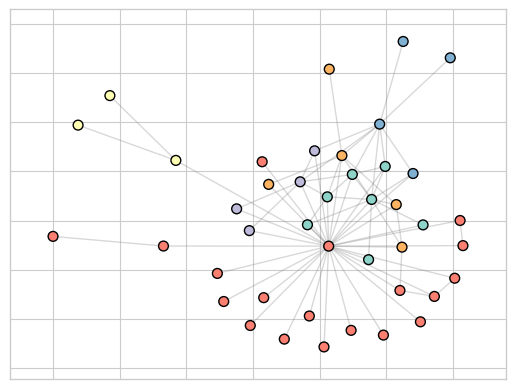

In [189]:
G = graphs_5G[12]
greedy_clusters, progress = greedy_clustering(G, num_steps = int(1e4))

draw_graph(G, clusters = greedy_clusters)
print(progress[-1])

In [180]:
# a = list(sorted((nx.weakly_connected_components(G))))
# H = G.subgraph(a[0])

# #nx.draw(H)

# greedy_clusters, progress = greedy_clustering(H, num_steps = int(1e4))

# draw_graph(H, clusters = greedy_clusters)
# print(progress[-1])

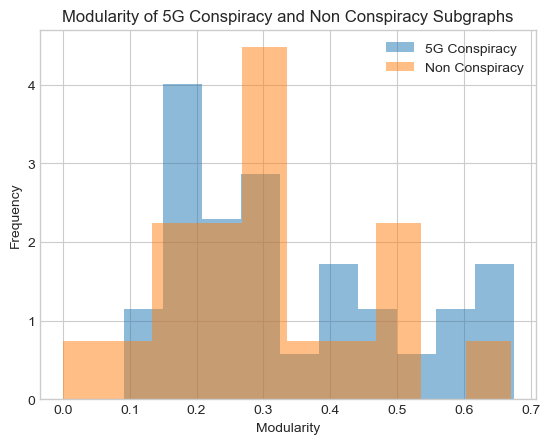

In [182]:
plt.hist(modularity_5G,density=True, alpha = 0.5, label = '5G Conspiracy')
plt.hist(modularity_nc,density=True, alpha=0.5, label = 'Non Conspiracy')
plt.xlabel('Modularity')
plt.ylabel('Frequency')
plt.title('Modularity of 5G Conspiracy and Non Conspiracy Subgraphs')
plt.legend()
plt.show()